# Самостоятельная работа
### Дедлайн 29.11.2024 23:59

# Задание
1. Создайте модель линейной регресии, которая будет состоять из Linear слоев и функций активации.
2. Напишите цикл обучения вашей линейной регрессии. В нейм реализайте подсчет функции потерь(код стандартной функции потерь написать самостоятельно), сделайте шаг градиентного спуска (код для градиентного спуска нужно писать самостоятельно). ЗАПРЕЩЕНО использовать готовые оптимизаторы и loss-функции из pytorch. Для подсчета градиента можно и нужно использовать метод backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графикм, метрики и значения функции потерь на тестовой и обучающей выборке.

Значения метрики **RMSE** (которую можно и нужно использовать как целевую) на тестовой выборке должна быть **меньше 11**, иначе **ОЦЕНКА** за данную задачу будет не больше **6 балов**.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
import torch.nn.functional as F

print(torch.__version__)

2.5.1+cu121


In [ ]:
!wget -O ./data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-11-27 20:58:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘./data.txt.zip’

./data.txt.zip          [       <=>          ] 201.24M  20.1MB/s    in 12s     

2024-11-27 20:58:31 (16.9 MB/s) - ‘./data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.dropna(axis=1)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263
6,2001,50.57546,33.17843,50.53517,11.55217,-27.24764,-8.78206,-12.04282,-9.53930,28.61811,...,11.63681,25.44182,134.62382,21.51982,8.17570,35.46251,11.57736,4.50056,-4.62739,1.40192
7,2001,48.26892,8.97526,75.23158,24.04945,-16.02105,-14.09491,8.11871,-1.87566,7.46701,...,18.03989,-58.46192,-65.56438,46.99856,-4.09602,56.37650,-18.29975,-0.30633,3.98364,-3.72556
8,2001,49.75468,33.99581,56.73846,2.89581,-2.92429,-26.44413,1.71392,-0.55644,22.08594,...,18.70812,5.20391,-27.75192,17.22100,-0.85210,-15.67150,-26.36257,5.48708,-9.13495,6.08680
9,2007,45.17809,46.34234,-40.65357,-2.47909,1.21253,-0.65302,-6.95536,-12.20040,17.02512,...,-4.36742,-87.55285,-70.79677,76.57355,-7.71727,3.26926,-298.49845,11.49326,-89.21804,-15.09719


In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  #  стандартизация признаков

train_size = 463715
X_train = X_scaled[:train_size, :]
y_train = y[:train_size]
X_test = X_scaled[train_size:, :]
y_test = y[train_size:]

# преобразование данных в тензоры в float32, чтобы они занимали меньше места
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [ ]:
print(X) # проверяю, что всё верно выполнилось

[[ 4.994357e+01  2.147114e+01  7.307750e+01 ... -1.822230e+00
  -2.746348e+01  2.263270e+00]
 [ 4.873215e+01  1.842930e+01  7.032679e+01 ...  1.204941e+01
   5.843453e+01  2.692061e+01]
 [ 5.095714e+01  3.185602e+01  5.581851e+01 ... -5.859000e-02
   3.967068e+01 -6.634500e-01]
 ...
 [ 4.512852e+01  1.265758e+01 -3.872018e+01 ... -6.071710e+00
   5.396319e+01 -8.093640e+00]
 [ 4.416614e+01  3.238368e+01 -3.349710e+00 ...  2.032240e+01
   1.483107e+01  3.974909e+01]
 [ 5.185726e+01  5.911655e+01  2.639436e+01 ... -5.515120e+00
   3.235602e+01  1.217352e+01]]


In [ ]:
print("Shape of original DataFrame:", df.shape) # узнаю размерность нашего датафрейма

Shape of original DataFrame: (515345, 91)


In [ ]:
print("Shape of X_train:", X_train.shape) # проверяю, что X_train выделен правильно

Shape of X_train: (463715, 90)


Text(0, 0.5, 'Год выпуска песни')

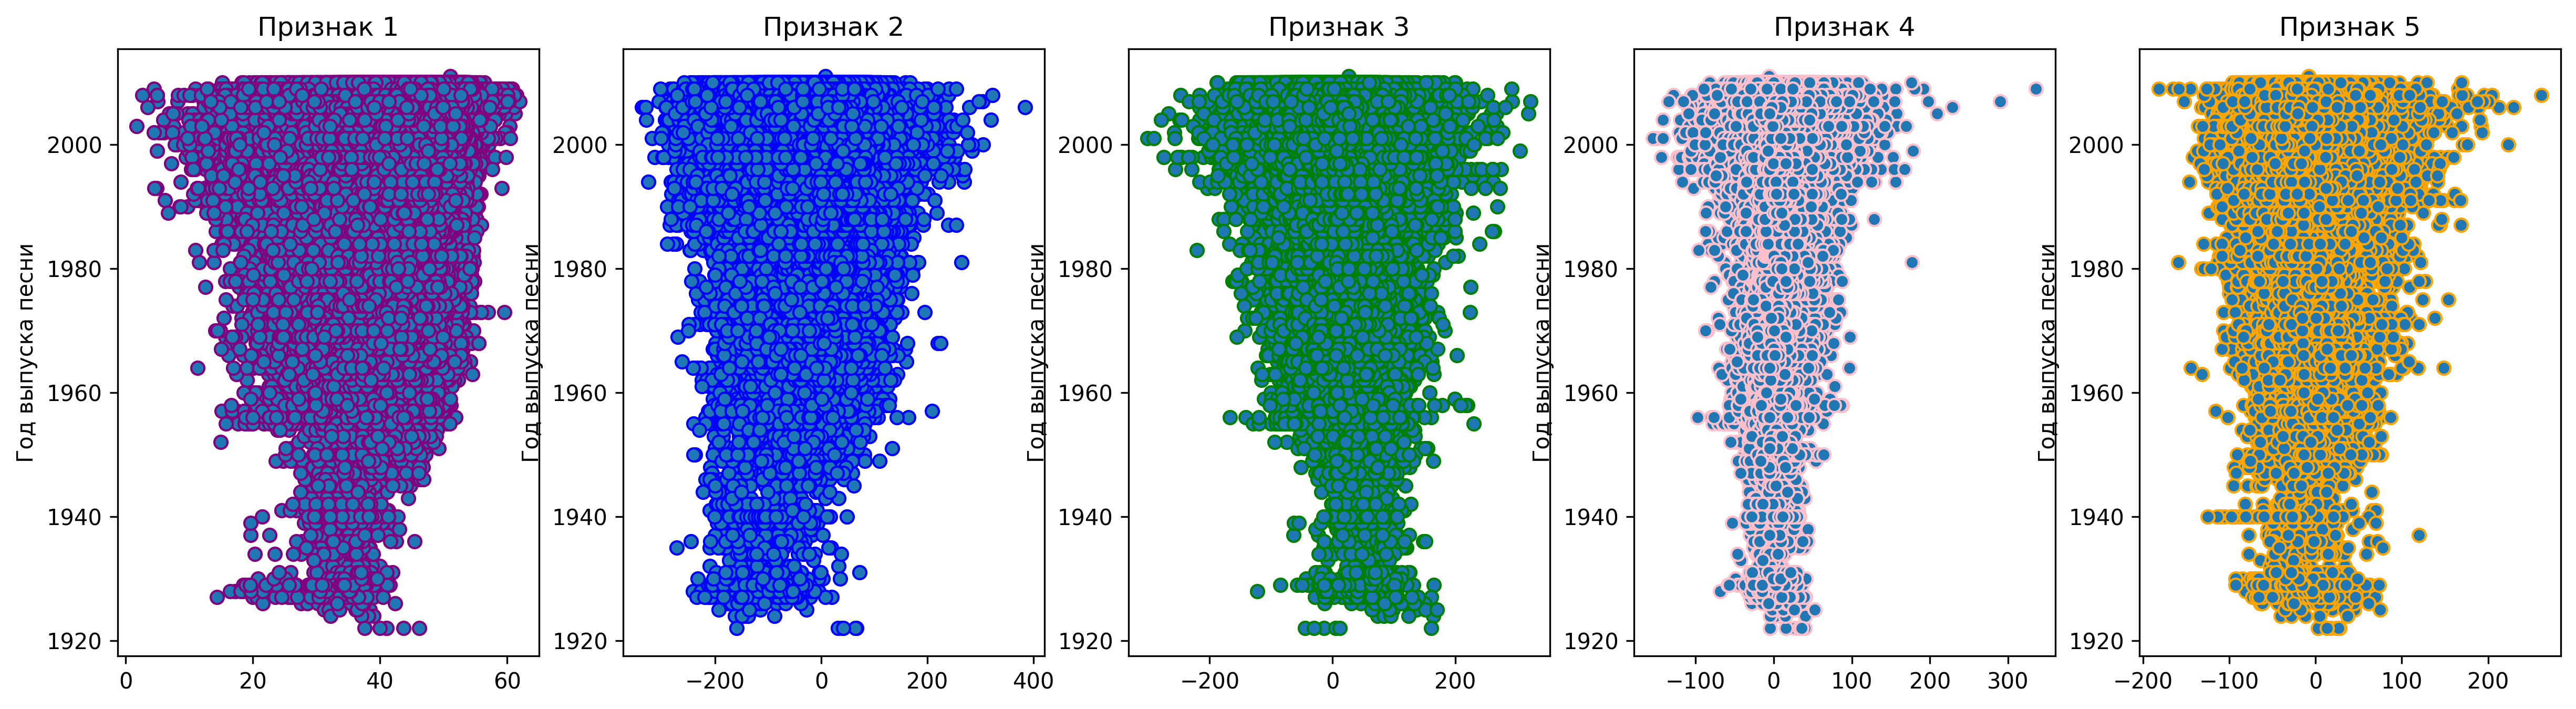

In [ ]:
# хочу для наглядности посомтреть на первые 10 признаков из нашего датафрейма, чтобы посмотреть есть ли какие-то закономерности

fig, axs = plt.subplots(1, 5, figsize=(20, 5), dpi=300)
axs[0].set_title('Признак 1')
axs[0].scatter(X[:, 0], y, edgecolor = 'purple')
axs[0].set_ylabel("Год выпуска песни")

axs[1].set_title('Признак 2')
axs[1].scatter(X[:, 1], y, edgecolor = 'blue')
axs[1].set_ylabel("Год выпуска песни")

axs[2].set_title('Признак 3')
axs[2].scatter(X[:, 2], y, edgecolor = 'green')
axs[2].set_ylabel("Год выпуска песни")

axs[3].set_title('Признак 4')
axs[3].scatter(X[:, 3], y, edgecolor = 'pink')
axs[3].set_ylabel("Год выпуска песни")

axs[4].set_title('Признак 5')
axs[4].scatter(X[:, 4], y, edgecolor = 'orange')
axs[4].set_ylabel("Год выпуска песни")

Text(0, 0.5, 'Год выпуска песни')

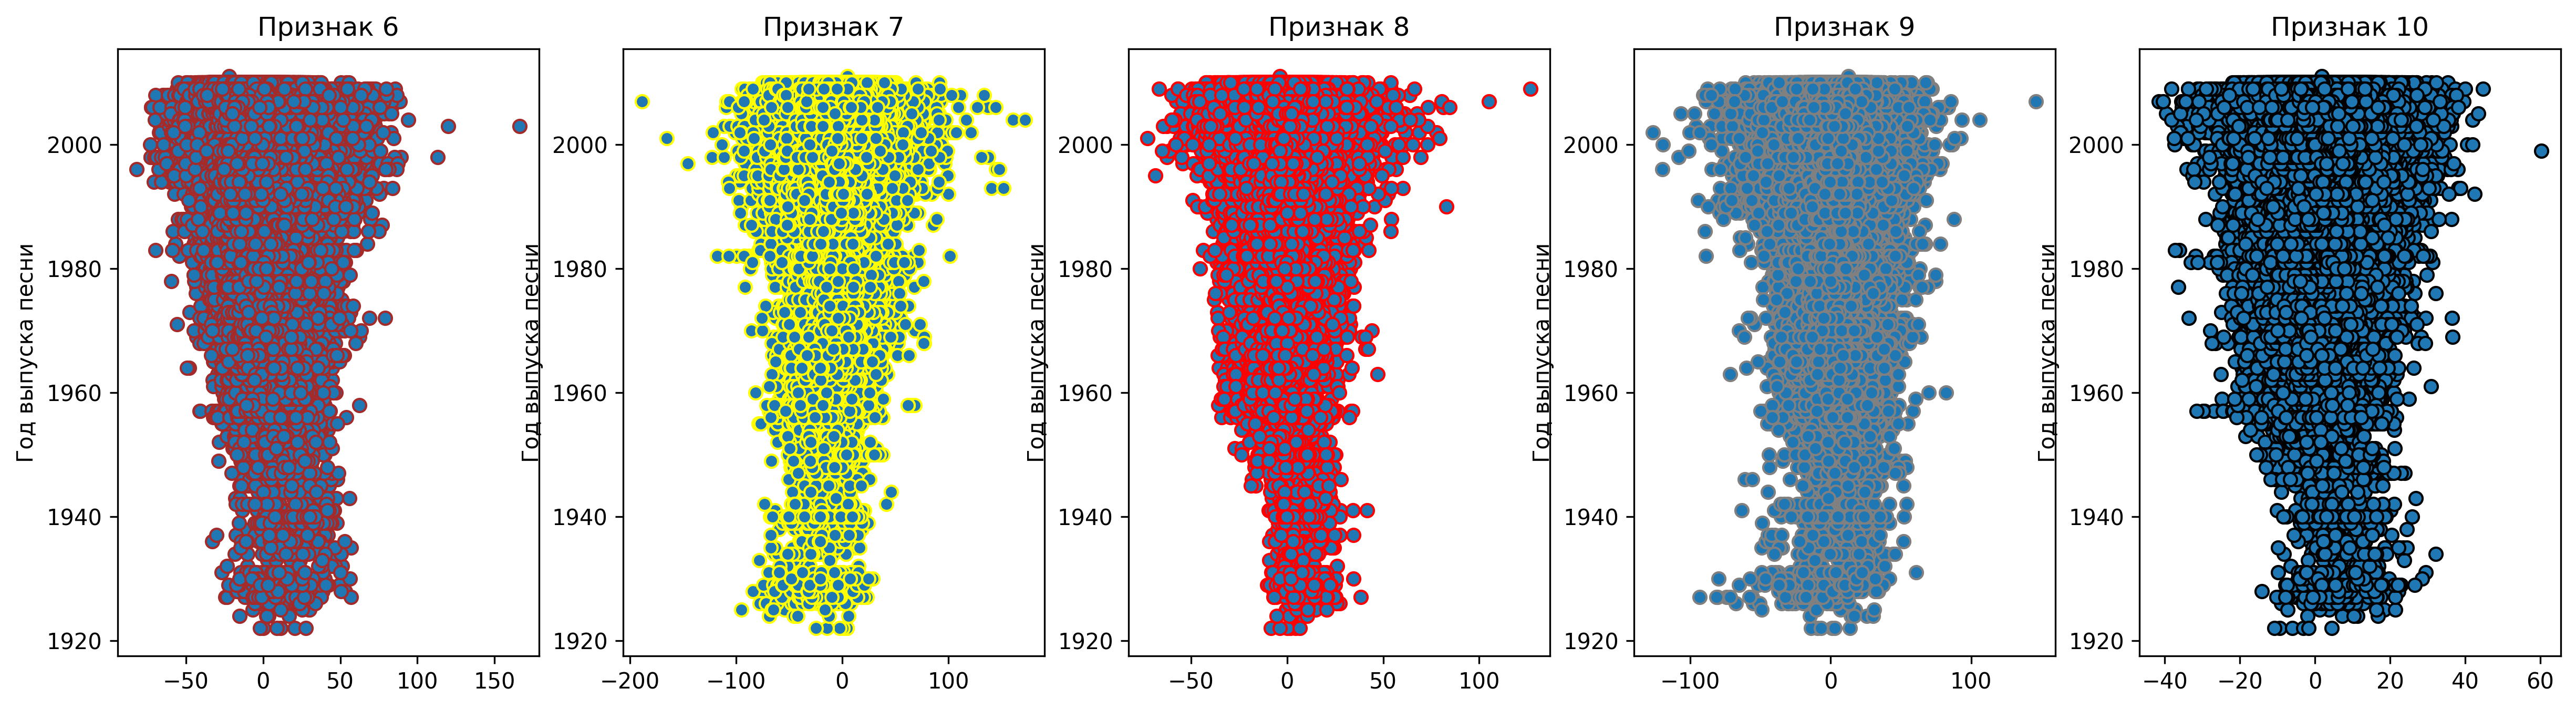

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5), dpi=300)
axs[0].set_title('Признак 6')
axs[0].scatter(X[:, 5], y, edgecolor = 'brown')
axs[0].set_ylabel("Год выпуска песни")

axs[1].set_title('Признак 7')
axs[1].scatter(X[:, 6], y, edgecolor = 'yellow')
axs[1].set_ylabel("Год выпуска песни")

axs[2].set_title('Признак 8')
axs[2].scatter(X[:, 7], y, edgecolor = 'red')
axs[2].set_ylabel("Год выпуска песни")

axs[3].set_title('Признак 9')
axs[3].scatter(X[:, 8], y, edgecolor = 'grey')
axs[3].set_ylabel("Год выпуска песни")

axs[4].set_title('Признак 10')
axs[4].scatter(X[:, 9], y, edgecolor = 'black')
axs[4].set_ylabel("Год выпуска песни")

Как мы видим, никакой зависимости выделить нельзя. Если смотреть на одни признаки, то с увелечением параметра будут более частотны одни года выпуска песен, а если смотреть на другие признаки, то и другие года будут более распространены.

In [ ]:
# фиксируем выборку

import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [ ]:
class NN(nn.Module):   # создаю модель с 3-мя линейными слоями
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)

        return x


model = NN(input_size=X_train.shape[1])

In [ ]:
def rmse_loss(y_pred, y_true):     # функция для нахождения ошибки RMSE
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

In [ ]:
learning_rate = 0.40 # значение learning rate выведен путем проб и ошибок :)


def update_weights(model, X, y, learning_rate):  # цикл обучения (без учета количества эпох)
    y_pred = model(X)
    loss = rmse_loss(y_pred, y)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        for i in model.parameters():
            i -= learning_rate * i.grad

    return loss.item()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # объединяем в одно X_train_tensor и y_train_tensor
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # хотим сократить кол-во запросов в базу данных

train_losses = []
test_losses = []

In [ ]:
for epoch in range(10):  # реализуем обучение на 10 эпохах
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in tqdm(train_loader):
        loss = update_weights(model, X_batch, y_batch, learning_rate)
        epoch_loss += loss

    train_losses.append(epoch_loss / len(train_loader))

    # Оценка на тестовой выборке
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)
        test_loss = rmse_loss(y_test_pred, y_test_tensor).item()
        test_losses.append(test_loss)

    print(f'Epoch {epoch + 1}/{10}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}') # выводим результат RMSE по train data и test data


100%|██████████| 7246/7246 [00:15<00:00, 462.74it/s]


Epoch 1/10, Train Loss: 13812345.3412, Test Loss: 10.8755


100%|██████████| 7246/7246 [00:15<00:00, 464.29it/s]


Epoch 2/10, Train Loss: 10.8306, Test Loss: 10.8713


100%|██████████| 7246/7246 [00:16<00:00, 449.19it/s]


Epoch 3/10, Train Loss: 10.8287, Test Loss: 10.8752


100%|██████████| 7246/7246 [00:16<00:00, 449.85it/s]


Epoch 4/10, Train Loss: 10.8296, Test Loss: 10.8719


100%|██████████| 7246/7246 [00:16<00:00, 435.64it/s]


Epoch 5/10, Train Loss: 10.8299, Test Loss: 10.8764


100%|██████████| 7246/7246 [00:15<00:00, 456.78it/s]


Epoch 6/10, Train Loss: 10.8272, Test Loss: 10.8717


100%|██████████| 7246/7246 [00:15<00:00, 464.56it/s]


Epoch 7/10, Train Loss: 10.8265, Test Loss: 10.8714


100%|██████████| 7246/7246 [00:16<00:00, 450.45it/s]


Epoch 8/10, Train Loss: 10.8283, Test Loss: 10.8734


100%|██████████| 7246/7246 [00:16<00:00, 442.07it/s]


Epoch 9/10, Train Loss: 10.8273, Test Loss: 10.8724


100%|██████████| 7246/7246 [00:15<00:00, 461.82it/s]


Epoch 10/10, Train Loss: 10.8255, Test Loss: 10.8714


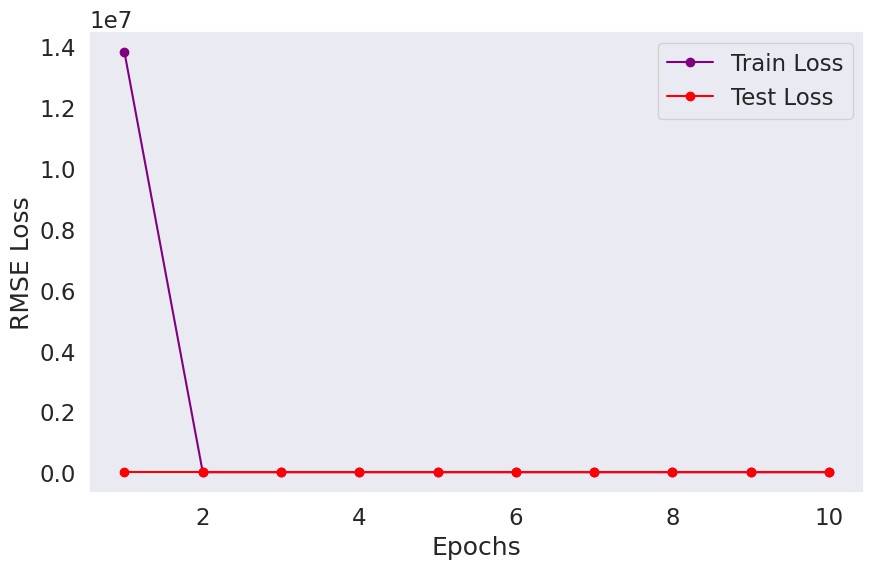

In [ ]:
epochs = range(1, len(train_losses) + 1)

sns.set(palette='Set2', font_scale=1.5)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='purple', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.legend()
plt.grid()
plt.show()